In [22]:
# celeba 데이터셋

# Pytorch GAN
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


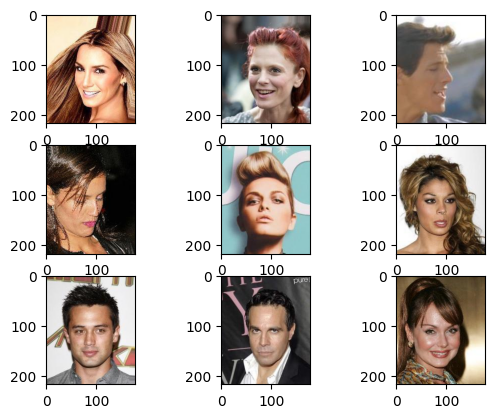

In [2]:
# 데이터셋 확인
import glob 
import matplotlib.pyplot as plt 
import os 
from PIL import Image 

# 이미지 경로
image_path = './dataset/img_align_celeba/'
images = glob.glob(os.path.join(image_path, '*'))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = Image.open(images[i])
    plt.imshow(img)

plt.show()

In [7]:
# 이미지 전처리 

import torch
import torchvision.transforms as tf 

from torchvision.datasets import ImageFolder 
from torch.utils.data.dataloader import DataLoader 

transforms = tf.Compose([
    tf.Resize(64),
    tf.CenterCrop(64),
    tf.ToTensor(),
    tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(
    root= "./dataset/",
    transform=transforms
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)


Dataset ImageFolder
    Number of datapoints: 202599
    Root location: ./dataset/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [16]:
# 생성자 
import torch.nn as nn 

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 생성자 구성 층 
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),

            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

# 판별자 
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 판별자 구성 
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [17]:
# 가중치 초기화 
# 가중치 평균 0, 표준편차 0.02, 정규분퐇
# 배치 정규화 평균 1.0, 표준편차 0.02 

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # 합성곱층 초기화 
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # 배치 정규화층 초기화 
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
# 학습 
import tqdm 

from torch.optim.adam import Adam 

device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)
epochs = 50

# 생성자
G = Generator().to(device)
# 생성자 가중치 초기화 
G.apply(weights_init)

# 판별자 정의
D = Discriminator().to(device)
# 판별자 가중치 초기화 
D.apply(weights_init)

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

# 루프
for epoch in range(epochs):
    iterator = tqdm.tqdm(enumerate(loader, 0), total=len(loader))

    for i, data in iterator:
        D_optim.zero_grad()

        # 실제 이미지는 1, 생성 이미지는 0으로 정답 설정 
        label = torch.ones_like(data[1], dtype=torch.float32).to(device)
        label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)

        # 실제 이미지를 판별자에 입력 
        real = D(data[0].to(device))

        # 실제 이미지에 대한 판별자의 오차 계산 
        Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
        Dloss_real.backward()

        # 가짜 이미지 생성 
        noise = torch.randn(label.shape[0], 100, 1,1, device=device)
        fake = G(noise)

        # 가짜 이미지 판별자에 입력
        output = D(fake.detach())

        # 가짜 이미지에 대한 판별자의 오차 계산
        Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
        Dloss_fake.backward()

        # 판별자의 전체 오차를 학습
        Dloss = Dloss_real + Dloss_fake 
        D_optim.step()

        # 생성자의 학습
        G_optim.zero_grad()
        output = D(fake)
        Gloss = nn.BCELoss()(torch.squeeze(output), label)
        Gloss.backward()

        G_optim.step()

        iterator.set_description(f"epoch:{epochs} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}")

torch.save(G.state_dict(), "Generator.pth")
torch.save(D.state_dict(), "Discrimiator.pth")


cpu


epoch:50 iteration:4 D_loss:0.4189523160457611 G_loss:4.0739874839782715:   0%|          | 5/1583 [00:03<16:42,  1.57it/s]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    G.load_state_dict(
        torch.load("Generator.pth", map_location=device)
    )
    feature_vector = torch.randn(1, 100, 1,1).to(device)
    pred = G(feature_vector).squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()

    plt.imshow(pred)
    plt.title("predicted image")
    plt.show()

